# DSCI 100 Project Final Report
## Section 008 | Group 23
## Chris Lee, Lucas Xu, Mark Evro, Max Svenson

In [2]:
library(tidyverse)
library(tidymodels)
library(repr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Introduction


## Background Information

In this investigation, we examine data collected from a real-world research initiative on the virtual video game Minecraft, conducted by the Probabilistic Learning and AI (PLAI) Group in the Department of Computer Science at the University of British Columbia. PLAICraft is an online, open-world Minecraft environment in which players explore the virtual landscape, build structures, participate in activities, and interact with one another. The dataset contains demographic information about players (such as age, gender, experience level) and corresponding player session details, including the number of hours they contributed to the server. The data also records whether each player is subscribed to a specific Minecraft-related newsletter.

The purpose of our analysis is to determine whether total playtime can serve as a meaningful predictor of newsletter subscription status among players within the PLAICraft server. To answer this question, we use the predictive modeling technique K-Nearest Neighbors (KNN) classification, creating a model that attempts to categorize players as subscribed or not subscribed based solely on the number of hours they spent on the server.

## Question: Can a player's total playtime predict newsletter subscription status in the players dataset?

The project lead Frank Wood originally posed the broader question:
- "What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?"

Our group created the narrower subquestion:
- "Can a player's total playtime predict newsletter subscription status in the players dataset?"

We examine only the player's total playtime as a predictor of newsletter subscription status, with the goal of assessing whether this single behavioral variable can be used to sufficiently identify subscribed and non-subscribed players.

## Dataset Overview

The `players.csv` dataset contains variables capturing player specific demographic and behavioral characteristics related to our proposed question. This includes the variable `played_hours`, measuring the individual's total play time on the Minecraft server, and `subscribe`, indicating whether or not a player subscribed to the game-related newsletter. The data for these variables will directly support predicting subscription status based on total playtime. 

Below is a table representing the variables of the dataset `players.csv`. Our group included a table summarizing the variables used in this project. The table lists each variable’s name, its type, and a brief description. The variable name corresponds directly to the column names in the dataset, allowing consistent reference across different analyses and visualizations. The variable type indicates whether a variable is numerical or categorical, helping clarify how each should be treated in the modeling process.

### **Variable Summary**

<br>

<p style="text-align: center;"><b>players.csv<b></p>
    
| Variable      | Type | Description |
| :----------- | :----------- | :------- |
| `experience`  | Character   | Player's Minecraft experience level (e.g. Beginner, Regular, Amateur, Pro, Veteran) |
| `subscribe`   | Logical     | Indicates whether the player subscribed to the game-related newsletter |
| `hashedEmail` | Character   | Encrypted player identifier used to link player data across datasets |
| `played_hours`| Double      | Total number of hours the player has spent on the server |
| `name`        | Character   | Player's chosen name |
| `gender`      | Character   | Gender of the player |
| `Age`         | Integer     | Player's age in years |


These variables provide the player information needed for our investigation (`played_hours` and `subscribe`). A second dataset `sessions.csv` also exists which contains more time details for player sessions, but is not needed for the aims of our research question. We have also included a further exploratation of two specific variables used in this investigation below: 

`played_hours` is a quantitative data type that totals the amount of cumulative hours a player has been online for.
- The mean session is 5.85 hours, the standard deviation is 28.36 hours.
- The minimum playtime is 0.00 hours, the median playtime is 0.10 hours, and the maximum playtime is 223.10 hours

`subscribe` is a boolean data type that describes whether the player is subscribed to the game related news letter. 
- 144 of the players are subscribed, making up 73.47% of the player base.
- 52 of the players are not subscribed, and make up the remaining 26.53% of the player base.

# Methods and Results

We start by importing the raw player data into the notebook, and the `subscribe` variable, a subscription indicator, was converted into a factor to increase the interpretability of the classification analysis; the original subscribe column was removed to avoid duplication. The dataset was then partitioned into  a training and testing subsets using a standard 75/25 split, with stratification applied to maintain the proportion of subscription outcomes in both sets. This ensures that the training and testing data reflect similar class distributions and provides a more reliable basis for evaluating model performance. Note that all required libraries are loaded at the very beginning of the file.

In [3]:
set.seed(0001) 

# Read in the raw data from the root directory (same folder) 
players_raw <- read_csv("players.csv") 

# Convert the subscription variable to a factor so it can be used for future analysis
# This will be used for splitting the data. 
players <- players_raw |> 
    mutate(subscription_status = factor(subscribe, 
                                       levels = c(TRUE, FALSE), 
                                       labels = c("Subscribed", "Not Subscribed"))) |> 
    select(-subscribe) 

# Create a split of 75 of the players dataframe, with the response being subscription status
players_split <- initial_split(players, prop = 0.75, strata = subscription_status) 
players_train <- training(players_split) 
players_test <- testing(players_split)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


The next step involves preparing the recipe and model specification needed to tune the K-NN classifier. The recipe applies scaling to the predictor so that playtime is measured on a consistent scale for distance-based calculations. A K-NN classification model is then defined with the number of neighbors set to tune(), allowing the tuning process to determine the most suitable value of K. To reduce the influence of random variation in the training set, a 10-fold cross-validation procedure is generated. This approach offers a more stable assessment of model performance across different values of K and helps identify a choice that generalizes reliably.

In [4]:
## Recipe with subscription_status as the responding, and played_hours as predictor. 
## We use the training data only , to minimize bias. 
players_recipe <- recipe(subscription_status ~ played_hours, data = players_train) |> 
    step_scale(all_predictors()) |> 
    step_center(all_predictors()) 

## Specification for model: each point has equal weighting (rectangular) for the classification model.  
## We also set the neighbors argument to tune() to find the optimal k value. 
players_spec_tune <- nearest_neighbor(weight_func  = "rectangular", neighbors = tune()) |> 
    set_engine("kknn")|> 
    set_mode("classification") 

## Create a vfold of 10 to ensure that random sampling doesn't influnence k as much. 
players_vfold <- vfold_cv(players_train, v = 10)

Choosing to index neighbors from 1 to 71, a tibble is created for tuning, which, along with the recipe and model, is entered into a workflow. Filtering for accuracy gives the results needed to examine how performance changes across different values of K. Next, using the accuracy values, the neighbor counts are plotted against their corresponding estimates to visualize how performance changes across different choices of K.

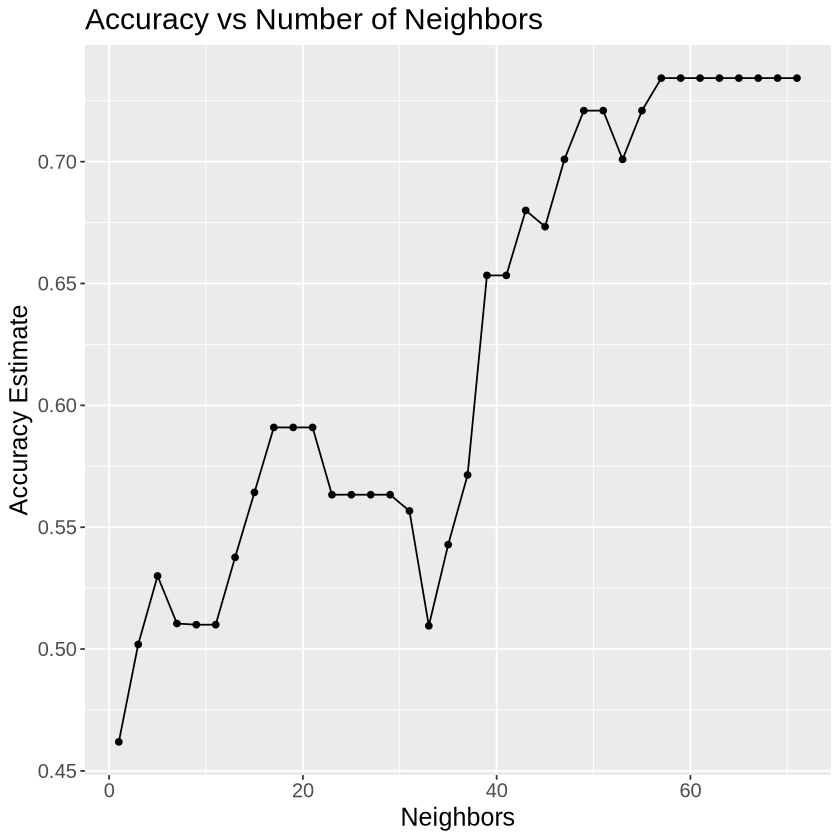

In [33]:
## Range of neighbors to be tested - set upper bound to 71 to observe tapering. 
grid_vals <- tibble(neighbors = seq(from = 1, to = 71, by = 2)) 

## Workflow to find ideal k value
players_results <- workflow() |> 
    add_recipe(players_recipe) |> 
    add_model(players_spec_tune) |> 
    tune_grid(resamples = players_vfold, grid = grid_vals) |> 
    collect_metrics() |>
    filter(.metric == "accuracy")

## Create a cross validation plot to find the ideal k value 
# ... NOTE: making the upper bound 71 shows tapering = model guesses the most popular target. 
# Boilerplate from tutorial classification 2 colution
# ... 
accuracy_vs_k <- ggplot(players_results, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = 'Neighbors', y = 'Accuracy Estimate', title = "Accuracy vs Number of Neighbors") + 
                  theme(text = element_text(size = 15))
                  # theme(text = element_text(size = 20)) +
                  # scale_x_continuous(breaks = seq(0, 20, 2)) +
                  # scale_y_continuous(limits = c(0.7, 0.85))

accuracy_vs_k

Looking at this cross-validation plot, the accuracy values begin to flatten once the neighbor count reaches the mid-50s. Since the goal is to select the k that produces the highest accuracy, and several neighboring values achieve similarly strong performance, the smallest k within this plateau region must be chosen for computational simplicity. Based on this criterion, a value of K = 57 is selected as the optimal choice for the classifier.

Both visually and mathematically, conclusion is that K = 57 has the highest accuracy.

In [31]:
best_k <- players_results |>
        arrange(desc(mean)) |>
        head(1)
best_k

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
57,accuracy,binary,0.7342857,10,0.03452007,Preprocessor1_Model29


With the chosen value of k identified, a new K-NN specification is created using this neighbor count instead of a tunable parameter. This updated model is then added to the workflow and fit to the training data. The fitted workflow serves as the finalized classifier that will be used to generate predictions on the testing set. The results are then passed onto players_pred_results and players_conf_mat to generate prediction accuracy and confusion matrix.

In [8]:
## Create a new predictor model like players_spec but change neighbors (k) to best_k, 57
players_spec_57 <- nearest_neighbor(weight_func = "rectangular", neighbors = 57) |> 
    set_engine("kknn") |> 
    set_mode("classification") 

## Create a fit for players, with the new specification 
players_fit <- workflow() |> 
    add_recipe(players_recipe) |> 
    add_model(players_spec_57) |> 
    fit(data = players_train)

players_predictions <- predict(players_fit, players_test) |> 
    bind_cols(players_test)

players_pred_results <- players_predictions |> 
     metrics(truth = subscription_status, estimate = .pred_class) |>
     filter(.metric == "accuracy")

players_conf_mat <- players_predictions |> 
     conf_mat(truth = subscription_status, estimate = .pred_class)

players_pred_results
players_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939


                Truth
Prediction       Subscribed Not Subscribed
  Subscribed             36             13
  Not Subscribed          0              0

The final model achieves an accuracy of approximately 73% (0.73) on the testing set, indicating that total playtime alone provides a reasonable ability to classify between subscribers and non-subscribers. The confusion matrix shows one interesting result as it didn't label any oberservation as `Not Subscribed`. This requires further investigation as this may signal (1) that the classifier performs well on predicting subscribers but its ability to identify non-subscribers is limited due to the small number of observations in that class or (2) that the classifier is functionally identical to the majority classifier and thus it is completely a poor classfier. At a glance, the model captures a meaningful pattern in the data, though there remains room for improvement with additional predictors.

A confusion matrix heatmap is used to visualize the classifier’s performance on the testing set. Each cell represents the number of predictions made for a given true class, with darker blude shading indicating higher counts. This provides a clear overview of where the model predicts accurately and where misclassifications occur.

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


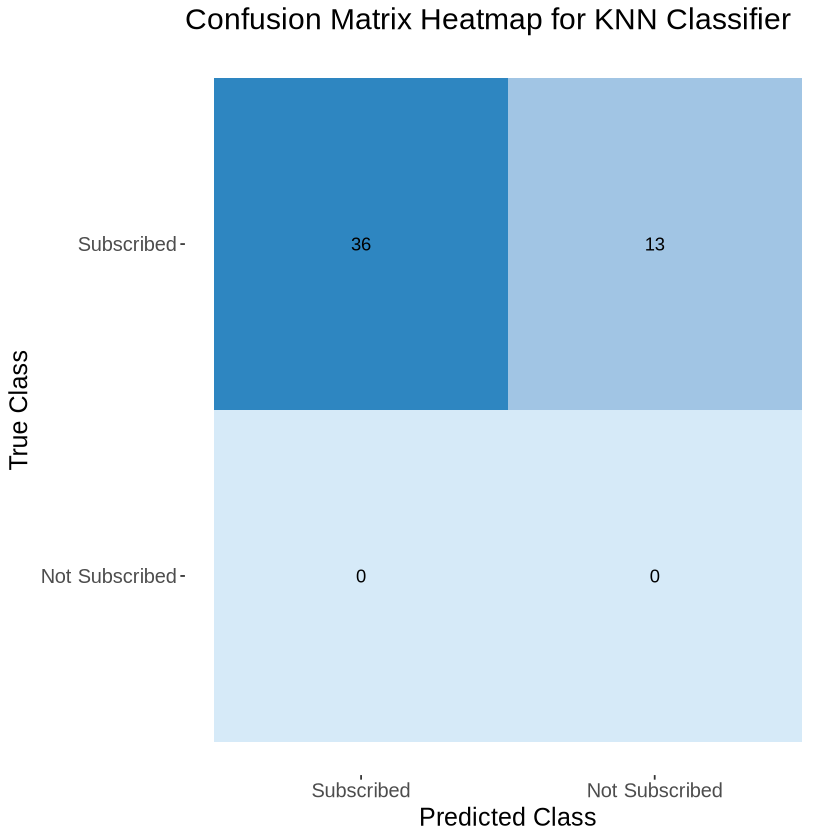

In [9]:
conf_mat_heatmap <- autoplot(players_conf_mat, type = "heatmap") +
  labs(
    title = "Confusion Matrix Heatmap for KNN Classifier",
    x = "Predicted Class",
    y = "True Class"
  ) +
  scale_fill_gradient(low = "#D6EAF8", high = "#2E86C1") +
  theme(text = element_text(size = 15))

conf_mat_heatmap

To carry out further investigation on this classifier model, a majority classifier was created, which simply predicts that every player is subscribed. This serves as a reference model since it reflects the dominant class in the dataset and represents the simplest possible classifier. The accuracy of this baseline was computed on the testing set and compared to that of the tuned KNN model. This comparison helps evaluate whether the KNN classifier offers meaningful improvement beyond a trivial prediction rule.

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939


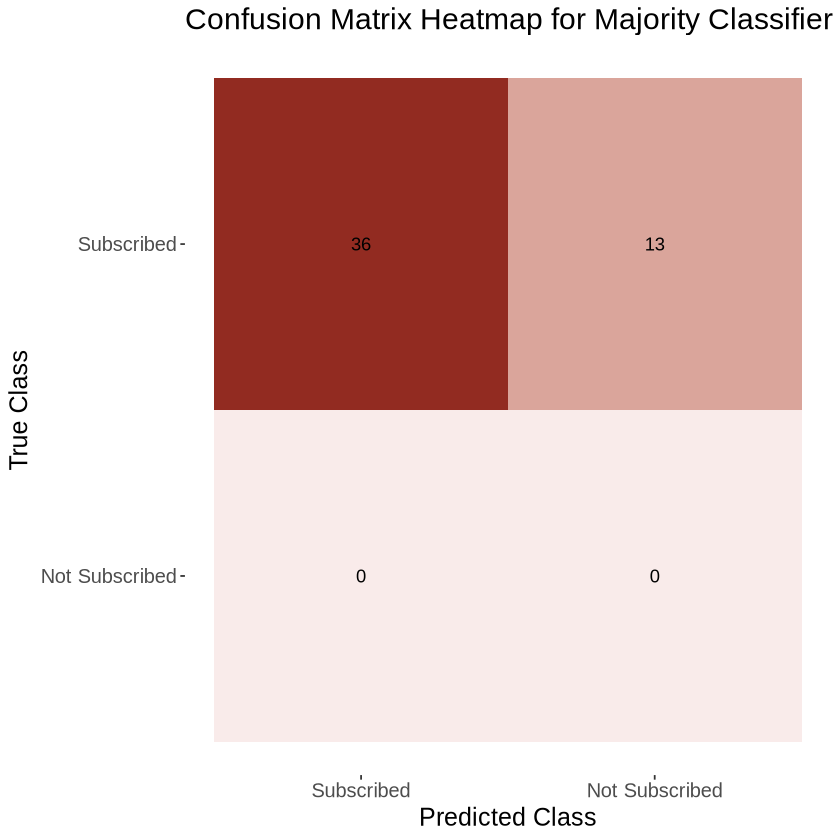

In [10]:
majority_class <- players_train |>
  count(subscription_status) |>
    slice_max(n) |>
    pull(subscription_status)

majority_predictions <- players_test |>
  mutate(pred_majority = majority_class)

majority_results <- majority_predictions |>
  metrics(truth = subscription_status, estimate = pred_majority) |>
  filter(.metric == "accuracy")

majority_conf_mat <- majority_predictions |>
  conf_mat(truth = subscription_status, estimate = pred_majority)

majority_conf_mat_heatmap <- autoplot(majority_conf_mat, type = "heatmap") +
  labs(
    title = "Confusion Matrix Heatmap for Majority Classifier",
    x = "Predicted Class",
    y = "True Class"
  ) +
  scale_fill_gradient(low = "#F9EBEA", high = "#922B21") +
  theme(text = element_text(size = 15))

majority_results
majority_conf_mat_heatmap

The K-NN classifier achieves the exact same accuracy as the majority classifier, indicating that total playtime alone does not provide enough information to distinguish subscribers from non-subscribers. Moreover, as it can be observed in the Confusion Matrix Heatmap for Majority Classifier, it looks identical to the Confusion Matrix Heatmap for K-NN Classifier. This shows that The classifier defaults to predicting the dominant class for nearly all observations, reflecting both the imbalance in the dataset and the weak relationship between playtime and subscription behaviour.

This time, to avoid K-NN classifier behaving exactly the same as the majority classifier, another prediction was performed on `players_test` with K = 20.

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.4897959


                Truth
Prediction       Subscribed Not Subscribed
  Subscribed             16              5
  Not Subscribed         20              8

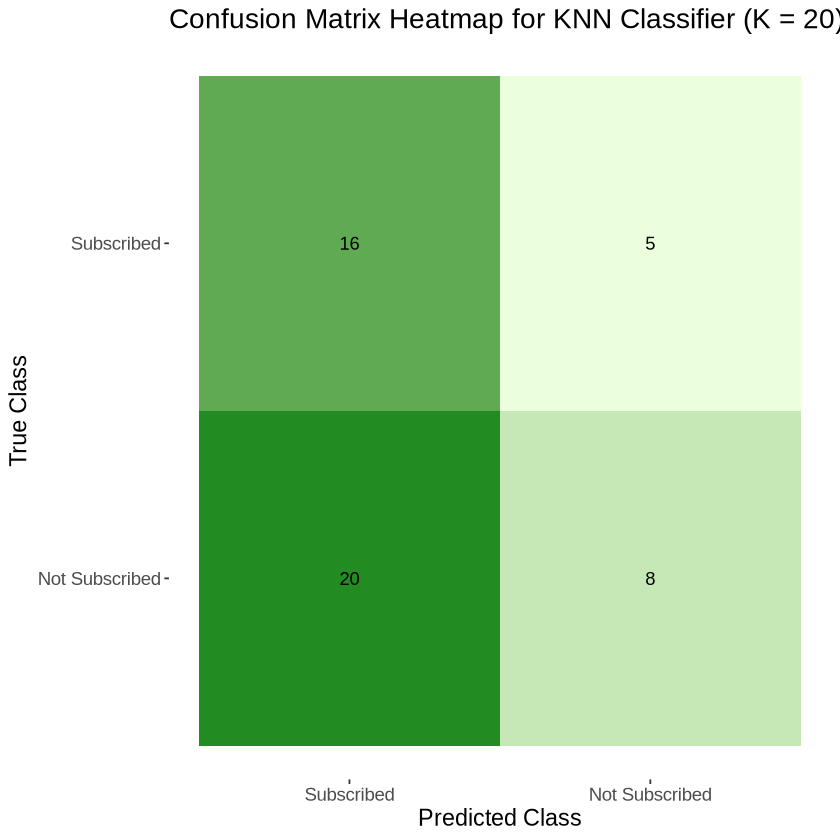

In [18]:
players_spec_20 <- nearest_neighbor(weight_func = "rectangular", neighbors = 20) |> 
    set_engine("kknn") |> 
    set_mode("classification") 

## Create a fit for players, with the new specification 
players_fit <- workflow() |> 
    add_recipe(players_recipe) |> 
    add_model(players_spec_20) |> 
    fit(data = players_train)

players_predictions <- predict(players_fit, players_test) |> 
    bind_cols(players_test)

players_pred_results <- players_predictions |> 
     metrics(truth = subscription_status, estimate = .pred_class) |>
     filter(.metric == "accuracy")

players_conf_mat_20 <- players_predictions |> 
     conf_mat(truth = subscription_status, estimate = .pred_class)

conf_mat_heatmap_20 <- autoplot(players_conf_mat_20, type = "heatmap") +
  labs(
    title = "Confusion Matrix Heatmap for KNN Classifier (K = 20)",
    x = "Predicted Class",
    y = "True Class"
  ) +
  scale_fill_gradient(low = "#ECFFDC", high = "#228B22") +
  theme(text = element_text(size = 14))


players_pred_results
players_conf_mat_20
conf_mat_heatmap_20

When a value of K = 20 is used instead of 57, a trade-off appears between the model’s accuracy and its tendency to behave like a majority classifier. Reducing K helps avoid the majority-class prediction behaviour, but the accuracy drops significantly to about 49%. This further supports the conclusion of this investigation: the model performs poorly, and there is no meaningful relationship between `played_hours` and `subscribe` status.

Lastly, below, we have included a histogram of `played_hours` which shows the distribution of the total playtime among all players in the original dataset. This will be used to support our explanation in the following Discussion section.

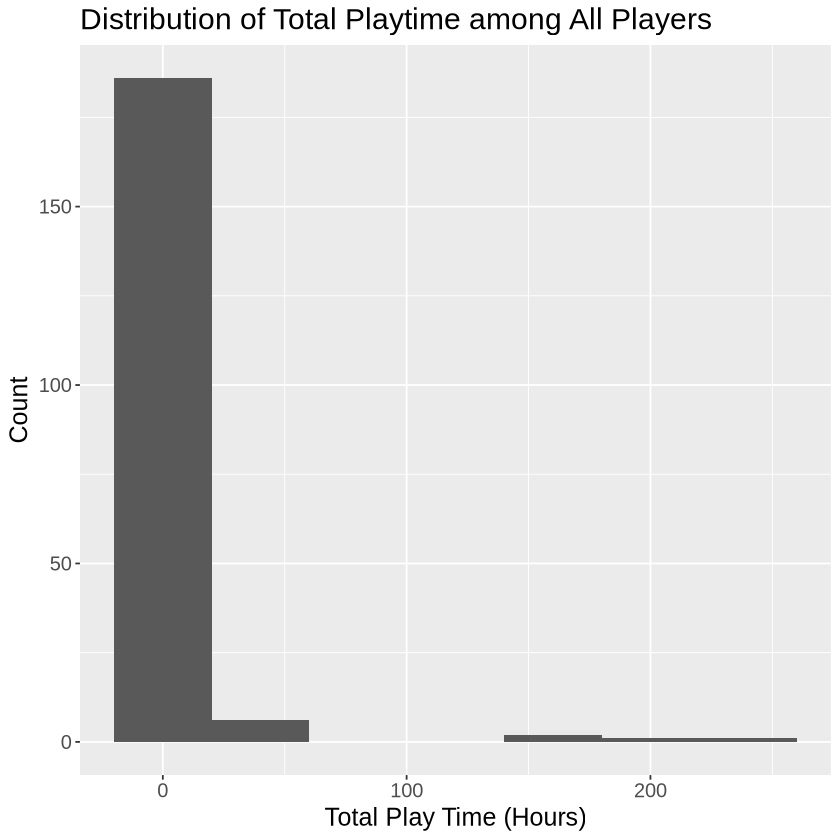

In [30]:
playtime_hist <- players_raw |>
    ggplot(aes(played_hours)) +
    geom_histogram(binwidth = 40) +
    labs(x = "Total Play Time (Hours)",
         y = "Count",
         title = "Distribution of Total Playtime among All Players") +
    theme(text = element_text(size = 15))

playtime_hist

## Discussion
### Model Summarization
Compared to the other algorithms in the scope of the course, K-NN classification is the only and therefore most suitable choice for answering our research question. It is simple and requires few assumptions about what the data looks like. 

However, when using K-NN classification, it is important to recognize the limitations of the data. For example, based on the play time histogram, we can see almost all players have 0 hours of play time, which would make classifying very difficult, because K-NN relies on differences in predictor values to distinguish between classes, and these points all share the same value (0 hours) despite having different subscription statuses.

### Findings
Based on our investigations, we conclude that play time is not a valid nor reliable variable to classify subscription status for players on the PLAICraft server. We performed 10-fold cross-validation on the training data subset to find an optimal number of neighbours of K = 57 and an accuracy of 73.43%. Notably, when testing our model with our unseen training data, we got a very similar accuracy of 73.47%. 

As mentioned above, the distribution of our data is very right skewed, with almost all of our data having a play time of 0. We would therefore expect the classifier to have difficulty classifying new data, since our singular predictor variable has very little variability. When we analyzed the confusion matrix, we found that the model appeared to be a majority classifier, as it did not classify a single point as “Not Subscribed.” To confirm this, we manually designed a majority classifier that classified every point as the majority class (“Subscribed”), and tested it on the testing set. Comparing the two models’ accuracies, we found that they had the exact same result, confirming that our trained classifier was indeed a majority classifier.

While our classifier performs relatively well with an accuracy of 73.47% on our testing data, we confirmed that it would not work on a different dataset with more variability in play time and an even distribution of subscription status as it is a majority classifier. Therefore we conclude that using the K-NN classification model results in a poorly performing model, and that play time is not a reliable predictor in investigating the subscription status of a player to the newsletter.

### Possible Improvements
From the data collected from PLAICraft, the server lacks enough data and dedicated players to create a diverse and distributed dataset that the classification model can use. If we were to try classifying with a larger dataset, from a larger Minecraft server such as Hypixel, with 18,000,000+ unique players (Simon, 2020), the data would be more spread out, and therefore our classification model would be more effective.

### Further Questions
Given that the K-NN model largely behaved as a majority classifier and that play time proved to be an ineffective predictor of subscription status, several questions remain unanswered. For example, how effective might the K-NN model be on a larger, more diverse dataset, and would play time be an effective predictor of subscription status on a larger, more diverse dataset? Regarding new avenues of research, how does age influence play time or experience level, and how does gender influence play time?

Collectively, these questions outline the limitations of the present study while pointing towards meaningful paths for future exploration, concluding our study.


### References
Simon [@Simon_Hypixel]. (2020, April 6).We just hit 18,000,000 unique players on the Hypixel Minecraft server! [Post]. X. https://x.com/Simon_Hypixel/status/1247368318018883584

